# Nutrition Tracker Survival Analysis
by: Andy Luc

## Business case:
Health and fitness has always been a topic of interest to me and I am fairly active when it comes to staying in shape. Part of that journey involves the consistency of tracking nutritional intake. One of the most popular apps today is MyFitnessPal, which tracks this on a daily basis.

Based on only user inputs of daily food intake and a target goal:
1. Can we predict when or if a user decides to churn or quit using the app?

2. Is there a certain nutritional item that contributes to a user quitting the platform?


### Pickled files:
Save processing time when loading into a dataframe.

- final_churn.pkl
- df.pkl
- nutri_per_day.pkl

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime
from lifelines import CoxPHFitter
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from functions import (json, pandas, daily_totals, daily_goals, merge, 
                       parsed_dict, end_date_col, find_date)
plt.style.use('seaborn')
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Exploratory Data Analysis

In [2]:
# Reading the data file
raw_data = pd.read_csv('data/mfp-diaries.tsv',
                  sep='\t',
                  header=None,
                  names=['userid','diary_date','food_entries','daily_goal'])

In [3]:
raw_data.head()

,userid,diary_date,food_entries,daily_goal
0,1,2014-09-14,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2924}..."
1,1,2014-09-15,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2430}..."
2,1,2014-09-16,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 1862}..."
3,1,2014-09-17,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2251}..."
4,1,2014-09-18,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2001}..."


In [4]:
# Number of unique users
len(raw_data['userid'].unique())

9896

### Setting up dataframe for Survival Analysis
Since we are concerned with when a user decides to stop using the MyFitnessPal program based on their input attributes, I am going to focus on the *diary_date* and *daily_goal* columns. First, we need to parse the nested dictionary within the daily_goal column.

In [5]:
# Parsing only the dialy_goals column
d_goal = raw_data.drop(['userid', 'diary_date','food_entries'], axis=1)

In [6]:
d_goal.head()

,daily_goal
0,"{""total"": [{""name"": ""Calories"", ""value"": 2924}..."
1,"{""total"": [{""name"": ""Calories"", ""value"": 2430}..."
2,"{""total"": [{""name"": ""Calories"", ""value"": 1862}..."
3,"{""total"": [{""name"": ""Calories"", ""value"": 2251}..."
4,"{""total"": [{""name"": ""Calories"", ""value"": 2001}..."


In [7]:
# Loading into json format for extraction
data = json.loads(d_goal['daily_goal'][0])
data

{'total': [{'name': 'Calories', 'value': 2924},
  {'name': 'Carbs', 'value': 340},
  {'name': 'Fat', 'value': 114},
  {'name': 'Protein', 'value': 186},
  {'name': 'Sodium', 'value': 3658},
  {'name': 'Sugar', 'value': 109}],
 'goal': [{'name': 'Calories', 'value': 3173},
  {'name': 'Carbs', 'value': 396},
  {'name': 'Fat', 'value': 105},
  {'name': 'Protein', 'value': 160},
  {'name': 'Sodium', 'value': 2300},
  {'name': 'Sugar', 'value': 119}]}

### Create 1 column per dictionary in both total key and goal key

- total
    + total_calories
    + total_carbs
    + total_fat
    + total_fiber
    + total_protein
    + total_sodium
    + total_sugar
- goal
    + goal_calories
    + goal_carbs
    + goal_fat
    + goal_fiber
    + goal_protein
    + goal_sodium
    + goal_sugar

In [11]:
total_dict = daily_totals(data)

goal_dict = daily_goals(data)

merge(total_dict, goal_dict)

full_list = parsed_dict(d_goal, data)

In [12]:
# Putting it back into a pandas dataframe
full_df = pd.DataFrame(full_list)
full_df.head()

,goal_calcium,goal_calories,goal_carbs,goal_chol,goal_fat,goal_fiber,goal_iron,goal_mon fat,goal_ply fat,goal_potass.,...,total_mon fat,total_ply fat,total_potass.,total_protein,total_sat fat,total_sodium,total_sugar,total_trn fat,total_vit a,total_vit c
0,NaN,3173.0,396.0,NaN,105.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,186.0,NaN,3658.0,109.0,NaN,NaN,NaN
1,NaN,1572.0,196.0,NaN,52.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,50.0,NaN,855.0,63.0,NaN,NaN,NaN
2,NaN,1832.0,229.0,NaN,61.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,114.0,NaN,2215.0,100.0,NaN,NaN,NaN
3,NaN,1685.0,210.0,NaN,56.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,98.0,NaN,1765.0,105.0,NaN,NaN,NaN
4,NaN,1597.0,199.0,NaN,53.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,202.0,NaN,1101.0,71.0,NaN,NaN,NaN


In [13]:
# Merging the original dataframe with the newly parsed daily_goal column
conn = pd.concat([raw_data, full_df], axis=1)

In [14]:
# Looking at the number of null values for each column
conn.isna().sum()

userid                 0
diary_date             0
food_entries           0
daily_goal             0
goal_calcium      564262
goal_calories          7
goal_carbs         14145
goal_chol         568935
goal_fat           17859
goal_fiber        344347
goal_iron         558171
goal_mon fat      587096
goal_ply fat      586693
goal_potass.      567771
goal_protein        7321
goal_sat fat      570611
goal_sodium       196659
goal_sugar        218272
goal_trn fat      585359
goal_vit a        586413
goal_vit c        584701
total_calcium     564262
total_calories        26
total_carbs        14146
total_chol        568935
total_fat          17866
total_fiber       344349
total_iron        558171
total_mon fat     586759
total_ply fat     586426
total_potass.     567771
total_protein       7331
total_sat fat     570611
total_sodium      196660
total_sugar       218270
total_trn fat     585359
total_vit a       586413
total_vit c       584701
dtype: int64

In [16]:
# Dropping columns which have high null values which are not beneficial to the features being used
clean_df = conn.drop(['food_entries','daily_goal','goal_calcium','goal_chol',
                       'goal_iron','goal_mon fat','goal_ply fat','goal_potass.',
                       'goal_sat fat','goal_trn fat','goal_vit a','goal_vit c',
                       'total_calcium','total_chol','total_iron','total_mon fat',
                       'total_ply fat','total_potass.','total_sat fat','total_trn fat',
                       'total_vit a','total_vit c'], axis=1)

In [17]:
# Fill the remaining null values of each nutrient with 0
clean_df.fillna(0, inplace=True)

In [18]:
# Changing diary_date column to a datetime type
clean_df['diary_date'] = pd.to_datetime(clean_df['diary_date'])

In [19]:
clean_df.head()

,userid,diary_date,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,goal_sodium,goal_sugar,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar
0,1,2014-09-14,3173.0,396.0,105.0,0.0,160.0,2300.0,119.0,2924.0,340.0,114.0,0.0,186.0,3658.0,109.0
1,1,2014-09-15,1572.0,196.0,52.0,0.0,79.0,2300.0,59.0,2430.0,96.0,37.0,0.0,50.0,855.0,63.0
2,1,2014-09-16,1832.0,229.0,61.0,0.0,92.0,2300.0,69.0,1862.0,158.0,54.0,0.0,114.0,2215.0,100.0
3,1,2014-09-17,1685.0,210.0,56.0,0.0,85.0,2300.0,63.0,2251.0,187.0,60.0,0.0,98.0,1765.0,105.0
4,1,2014-09-18,1597.0,199.0,53.0,0.0,80.0,2300.0,60.0,2001.0,113.0,81.0,0.0,202.0,1101.0,71.0


Add additional columns:
- **total_sum**: Total sum of input values for the day
- **goal_sum**: Total sum of goal values for the day
- **achievement**: Indicates whether or not a user has met their daily goal within a tolerance of 10%.
    - 1 = Succeed
    - 0 = Fail

In [20]:
nutrients = ['calories','carbs','fat','fiber','protein','sodium','sugar']

total_s = []
goal_s = []
for nutrient in nutrients:
    total_s.append(f'total_{nutrient}')
    goal_s.append(f'goal_{nutrient}')

clean_df['total_sum'] = clean_df[total_s].apply(np.sum, axis=1)

clean_df['goal_sum'] = clean_df[goal_s].apply(np.sum, axis=1)

clean_df['achievement'] = np.where(abs((clean_df['total_sum'] - 
                                          clean_df['goal_sum']) / 
                                          clean_df['goal_sum']) <= 0.1, 1, 0)

In [23]:
clean_df.head()

,userid,diary_date,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,goal_sodium,goal_sugar,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement
0,1,2014-09-14,3173.0,396.0,105.0,0.0,160.0,2300.0,119.0,2924.0,340.0,114.0,0.0,186.0,3658.0,109.0,7331.0,6253.0,0
1,1,2014-09-15,1572.0,196.0,52.0,0.0,79.0,2300.0,59.0,2430.0,96.0,37.0,0.0,50.0,855.0,63.0,3531.0,4258.0,0
2,1,2014-09-16,1832.0,229.0,61.0,0.0,92.0,2300.0,69.0,1862.0,158.0,54.0,0.0,114.0,2215.0,100.0,4503.0,4583.0,1
3,1,2014-09-17,1685.0,210.0,56.0,0.0,85.0,2300.0,63.0,2251.0,187.0,60.0,0.0,98.0,1765.0,105.0,4466.0,4399.0,1
4,1,2014-09-18,1597.0,199.0,53.0,0.0,80.0,2300.0,60.0,2001.0,113.0,81.0,0.0,202.0,1101.0,71.0,3569.0,4289.0,0


### Create Multi-Collinearity Heatmap
This is just to show if any columns have collinear values. We would essentially drop a certain column if the value they are highly correlated, but in this case we want to keep the features as they may pertain to the survival analysis model. As you can see sugar and carbs are correlated, which we can say is a true statement.

In [ ]:
coll = clean_df.drop(['userid','diary_date','goal_calories','goal_carbs',
                        'goal_fat','goal_fiber','goal_protein','goal_sodium',
                        'goal_sugar','total_sum','goal_sum'], axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(coll.corr(), center=0, cmap='BrBG', annot=True)

ax.set_title('Multi-Collinearity of Attributes')

## Survival Analysis
Min & Max Diary Dates: Sept 14, 2014 - Apr 9, 2015

In [ ]:
# Creates a new column with the previous date of the diary_date column
end_date_col(clean_df)

In [ ]:
clean_df = pd.read_pickle('pkl/end_date.pkl')

In [ ]:
clean_df.head()

In [ ]:
clean_df.info()

### Verify filter that is only keeping records of diary_date that occured before 4-6-2015.

In [28]:
from datetime import datetime

cutoff_date = datetime.strptime('2015-04-06','%Y-%m-%d')
cutoff_date

datetime.datetime(2015, 4, 6, 0, 0)

In [29]:
print(clean_df.loc[clean_df['diary_date'] >= cutoff_date, :].shape)

print(clean_df.loc[clean_df['diary_date'] < cutoff_date, :].shape)

print(clean_df.shape)

(1074, 19)
(586113, 19)
(587187, 19)


Of 1074 records, how many unique users are there that enter data past 2015-4-5

In [30]:
len(clean_df.loc[clean_df['diary_date'] >= cutoff_date, 'userid'].unique())

622

In [31]:
clean_df = clean_df.loc[clean_df['diary_date'] < cutoff_date, :]

In [32]:
clean_df.tail()

,userid,diary_date,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,goal_sodium,goal_sugar,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement
587182,9897,2015-03-02,2017.0,252.0,67.0,22.0,101.0,0.0,76.0,1979.0,146.0,101.0,19.0,103.0,0.0,38.0,2386.0,2535.0,1
587183,9897,2015-03-03,1799.0,225.0,60.0,20.0,90.0,0.0,67.0,2141.0,150.0,93.0,20.0,147.0,0.0,29.0,2580.0,2261.0,0
587184,9897,2015-03-04,1920.0,240.0,64.0,21.0,96.0,0.0,72.0,543.0,54.0,22.0,4.0,31.0,0.0,8.0,662.0,2413.0,0
587185,9897,2015-03-14,2118.0,265.0,71.0,23.0,106.0,0.0,79.0,2024.0,160.0,100.0,9.0,113.0,0.0,22.0,2428.0,2662.0,1
587186,9897,2015-03-15,1920.0,240.0,64.0,21.0,96.0,0.0,72.0,1496.0,132.0,103.0,11.0,54.0,0.0,52.0,1848.0,2413.0,0


In [33]:
len(clean_df['userid'].unique())

9890

### Exploratory Analysis with *"clean_df"* dataframe

In [34]:
user = clean_df[clean_df['userid'] == 3]

print(user.diary_date.diff().value_counts())
print('\n')
print(user.diary_date.value_counts().sum())

user[user.diary_date.diff() > pd.Timedelta(3, 'D')]

1 days    5
4 days    1
Name: diary_date, dtype: int64


7


,userid,diary_date,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,goal_sodium,goal_sugar,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement
240,3,2014-09-23,1210.0,151.0,40.0,25.0,60.0,2300.0,0.0,1208.0,173.0,30.0,11.0,34.0,1707.0,0.0,3163.0,3786.0,0


In [35]:
clean_df.loc[0, 'end_date'] - clean_df.loc[0, 'diary_date']

KeyError: 'the label [end_date] is not in the [index]'

Using the function **find_date**, we can setup a dataframe with the start date and when they churn for all userid's. If they have not churned, NaT is there to indicate "Not a Time."

In [ ]:
date = pd.DataFrame(find_date(clean_df))
date.head()

In [ ]:
date['days'] = (date['churn_date'] - date['start_date']).dt.days
date.head()

In [ ]:
date['churn_5days'] = date['churn_date'].apply(lambda x: 0 if type(x) is not pd.Timestamp else 1)
date.head()

In [ ]:
days_count = clean_df['userid'].value_counts().sort_index()
days_count = pd.DataFrame(days_count).rename(columns={'userid': 'days_count'})
days_count.head()

In [ ]:
churn = pd.merge(days_count, date, left_index=True, right_on='userid')
churn.index = churn['userid']
churn = churn.drop('userid', axis=1)

In [ ]:
churn.head()

In [ ]:
churn.days.fillna(churn.days_count, inplace=True)
churn.head()

In [ ]:
# Merging "final_churn" and "total_goal" dataframes
cols = clean_df.drop(['userid','diary_date'], axis=1).columns

condense = clean_df.groupby(['userid'])[cols].sum()

svl = pd.merge(churn, condense, left_index=True, right_index=True)

In [ ]:
# Creates 7 new columns calculating whether or not a user has reached within 10% of their goal,
# for the duration of the time using the app
nutrients = ['calories','carbs','fat','fiber','protein','sodium','sugar']

for nutrient in nutrients:
    total = svl[f'total_{nutrient}']
    goal = svl[f'goal_{nutrient}']
    svl[f'{nutrient}_10_pct'] = np.where(abs((total - goal) / goal) <= 0.1, 1, 0)

In [ ]:
svl.head()

In [ ]:
svl.drop(svl.columns.difference(['days','churn_5days','achievement','calories_10_pct',
                                          'carbs_10_pct','fat_10_pct','fiber_10_pct','protein_10_pct',
                                          'sodium_10_pct','sugar_10_pct']), 1, inplace=True)

In [ ]:
svl.head()

In [ ]:
svl['churn_5days'].value_counts()

## Histogram of users that churned
## label graphs*

In [ ]:
h = svl.loc[svl['churn_5days'] == 1, 'days']

In [ ]:
plt.hist(h)

In [ ]:
z = svl.loc[svl['churn_5days'] == 0, 'days']
plt.hist(z)

### Cox Proportional Hazards Model:
1. duration_col = length of time between start date and time of churn
2. event_col = time of churn (when there is a break >=5 days)
    * churn = 1
    * continuous = 0

In [ ]:
# svl = pd.read_pickle('pkl/svl.pkl')
# svl.head()

In [ ]:
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter

cph_train, cph_test = train_test_split(svl, test_size=0.2)
cph = CoxPHFitter().fit(cph_train, 'days', 'churn_5days')
cph.print_summary()

## calories 10% has the worst p-value, hence drop.

In [ ]:
cph_train.drop(['calories_10_pct'], axis=1, inplace=True)

In [ ]:
cph_train.head()

In [ ]:
cph = CoxPHFitter().fit(cph_train, 'days', 'churn_5days')

cph.print_summary()

In [ ]:
cph_train.drop(['carbs_10_pct'], axis=1, inplace=True)

cph_train.head()

In [ ]:
cph = CoxPHFitter().fit(cph_train, 'days', 'churn_5days')

cph.print_summary()

In [ ]:
cph_train.drop(['fiber_10_pct'], axis=1, inplace=True)

cph_train.head()

In [ ]:
cph = CoxPHFitter().fit(cph_train, 'days', 'churn_5days')

cph.print_summary()

In [ ]:
cph_train.drop(['sugar_10_pct'], axis=1, inplace=True)

cph_train.head()

In [ ]:
cph = CoxPHFitter().fit(cph_train, 'days', 'churn_5days')

cph.print_summary()

### Results

1. We get the coefficients of our model. These are very important and they tell us how each feature increases risk, so if it’s a positive number that attribute makes a customer more likely to churn, and if it is negative then customers with that feature are less likely to churn.


2. concordance is an assessment of how internally consistent the model is – if it says a particular feature increases risk, the observations that have that feature should be more at risk. If they are the concordance goes up, if they’re not then it decreases.

In [ ]:
cph.plot()

In [ ]:
cph.plot_covariate_groups('sodium_10_pct', [0, 1], cmap='coolwarm')
plt.xlabel('Time (days)')
plt.ylabel('Risk (probability of churn)')
plt.title('Survival Analysis for Single Attribute')

In [ ]:
cph.plot_covariate_groups('protein_10_pct', [0, 1], cmap='coolwarm')
plt.xlabel('Time (days)')
plt.ylabel('Risk (probability of churn)')
plt.title('Survival Analysis for Single Attribute')

For example: At 25 days, there is a higher risk of churning based only on meeting protein goals. As a result, the company should provide some sort of marketing incentive for users to keep progressing at around the 25 day mark.

In [ ]:
censored_subjects = svl.loc[svl['churn_5days'] == 0]

In [ ]:
unconditioned_sf = cph.predict_survival_function(censored_subjects)

In [ ]:
conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[svl.loc[c.index, 'days']]).clip_upper(1))

In [ ]:
# cph = CoxPHFitter().fit(svl, duration_col='days', event_col='churn_5days')
# cph.print_summary()

In [ ]:
# cph.plot()

# TEST

In [46]:
end = pd.read_pickle('pkl/end_date.pkl')
end.head()

,userid,diary_date,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,goal_sodium,goal_sugar,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement,end_date
0,1,2014-09-14,3173.0,396.0,105.0,0.0,160.0,2300.0,119.0,2924.0,340.0,114.0,0.0,186.0,3658.0,109.0,7331.0,6253.0,0,2014-09-15
1,1,2014-09-15,1572.0,196.0,52.0,0.0,79.0,2300.0,59.0,2430.0,96.0,37.0,0.0,50.0,855.0,63.0,3531.0,4258.0,0,2014-09-16
2,1,2014-09-16,1832.0,229.0,61.0,0.0,92.0,2300.0,69.0,1862.0,158.0,54.0,0.0,114.0,2215.0,100.0,4503.0,4583.0,1,2014-09-17
3,1,2014-09-17,1685.0,210.0,56.0,0.0,85.0,2300.0,63.0,2251.0,187.0,60.0,0.0,98.0,1765.0,105.0,4466.0,4399.0,1,2014-09-18
4,1,2014-09-18,1597.0,199.0,53.0,0.0,80.0,2300.0,60.0,2001.0,113.0,81.0,0.0,202.0,1101.0,71.0,3569.0,4289.0,0,2014-09-19


In [48]:
cols = end.drop(['userid','diary_date', 'end_date'], axis=1).columns
perday_df = end.groupby(['userid'])[cols].sum()
perday_df.head()

,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,goal_sodium,goal_sugar,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement
userid,,,,,,,,,,,,,,,,,
1,375085.0,46633.0,12472.0,0.0,19029.0,400200.0,14076.0,401750.0,32265.0,13562.0,0.0,22408.0,360487.0,14227.0,844699.0,867495.0,68
2,90925.0,11387.0,2955.0,0.0,4714.0,138000.0,3422.0,87430.0,10872.0,2537.0,0.0,2550.0,100217.0,4573.0,208179.0,251403.0,11
3,9438.0,1178.0,312.0,196.0,469.0,16100.0,0.0,11969.0,811.0,267.0,120.0,323.0,10156.0,0.0,23646.0,27693.0,2
4,44211.0,5524.0,1464.0,0.0,2223.0,62100.0,0.0,24636.0,2682.0,1001.0,0.0,1153.0,40061.0,0.0,69533.0,115522.0,4
5,572414.0,0.0,15948.0,7564.0,35677.0,411700.0,21485.0,536631.0,0.0,13818.0,6305.0,33720.0,358700.0,21707.0,970881.0,1064788.0,58


In [49]:
perday_df = perday_df.drop(['goal_calories','goal_carbs','goal_fat','goal_fat',
                            'goal_fiber','goal_protein','goal_sodium','goal_sugar'], axis=1)

In [50]:
perday_df.head()

,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement
userid,,,,,,,,,,
1,401750.0,32265.0,13562.0,0.0,22408.0,360487.0,14227.0,844699.0,867495.0,68
2,87430.0,10872.0,2537.0,0.0,2550.0,100217.0,4573.0,208179.0,251403.0,11
3,11969.0,811.0,267.0,120.0,323.0,10156.0,0.0,23646.0,27693.0,2
4,24636.0,2682.0,1001.0,0.0,1153.0,40061.0,0.0,69533.0,115522.0,4
5,536631.0,0.0,13818.0,6305.0,33720.0,358700.0,21707.0,970881.0,1064788.0,58


In [81]:
test_svl = svl.drop(['achievement','calories_10_pct','carbs_10_pct','fat_10_pct',
                     'fiber_10_pct','protein_10_pct','sodium_10_pct','sugar_10_pct'], axis=1)

In [82]:
test_svl.head()

,days,churn_5days
userid,,
1,48.0,1
2,60.0,0
3,9.0,1
4,1.0,1
5,179.0,0


In [74]:
nutrients = ['calories','carbs','fat','fiber','protein','sodium','sugar']

for nutrient in nutrients:
    total = test[f'total_{nutrient}']
    days = test['days_count']
    test[f'{nutrient}_avg'] = (total / days).astype(int)

In [84]:
test = test.drop(['total_calories','total_carbs','total_fat',
                  'total_fat','total_fiber','total_protein',
                  'total_sodium','total_sugar','total_sum',
                  'goal_sum','days_count','achievement'], axis=1)

In [97]:
test.head()

,calories_avg,carbs_avg,fat_avg,fiber_avg,protein_avg,sodium_avg,sugar_avg
1,2308,185,77,0,128,2071,81
2,1457,181,42,0,42,1670,76
3,1709,115,38,17,46,1450,0
4,912,99,37,0,42,1483,0
5,2997,0,77,35,188,2003,121


In [98]:
test3 = pd.merge(test_svl, test, left_index=True, right_index=True)
test3.head()

,days,churn_5days,calories_avg,carbs_avg,fat_avg,fiber_avg,protein_avg,sodium_avg,sugar_avg
1,48.0,1,2308,185,77,0,128,2071,81
2,60.0,0,1457,181,42,0,42,1670,76
3,9.0,1,1709,115,38,17,46,1450,0
4,1.0,1,912,99,37,0,42,1483,0
5,179.0,0,2997,0,77,35,188,2003,121


In [99]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_curve, auc, precision_score, recall_score, accuracy_score,
f1_score, confusion_matrix, classification_report)

In [100]:
#Setting X and y variables, then Train Test Split
X = test3.drop(['churn_5days'], axis=1)
y = test3.churn_5days

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [101]:
loreg = LogisticRegression(solver='lbfgs', max_iter=1000)
loreg.fit(X_train, y_train)
loreg_preds = loreg.predict(X_test)

In [102]:
def print_metrics(y, loreg_preds):
    print("Precision Score: {}".format(precision_score(y, loreg_preds)))
    print("Recall Score: {}".format(recall_score(y, loreg_preds)))
    print("Accuracy Score: {}".format(accuracy_score(y, loreg_preds)))
    print("F1 Score: {}".format(f1_score(y, loreg_preds)))
    
print_metrics(y_test, loreg_preds)

Precision Score: 0.7666349809885932
Recall Score: 0.9238258877434136
Accuracy Score: 0.7476748887990295
F1 Score: 0.837922077922078


In [103]:
print(classification_report(y_test, loreg_preds))

              precision    recall  f1-score   support

           0       0.64      0.32      0.43       727
           1       0.77      0.92      0.84      1746

   micro avg       0.75      0.75      0.75      2473
   macro avg       0.70      0.62      0.63      2473
weighted avg       0.73      0.75      0.72      2473



AUC: 0.674619606063614


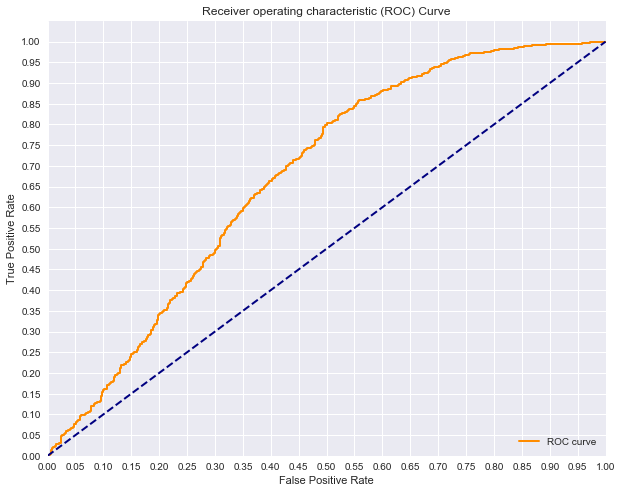

In [104]:
y_score = loreg.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# END TEST

## Logistic Regression

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_curve, auc, precision_score, recall_score, accuracy_score,
f1_score, confusion_matrix, classification_report)

In [106]:
#Setting X and y variables, then Train Test Split
X = svl.drop(['churn_5days'], axis=1)
y = svl.churn_5days

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [107]:
loreg = LogisticRegression(solver='lbfgs', max_iter=1000)
loreg.fit(X_train, y_train)
loreg_preds = loreg.predict(X_test)

In [108]:
def print_metrics(y, loreg_preds):
    print("Precision Score: {}".format(precision_score(y, loreg_preds)))
    print("Recall Score: {}".format(recall_score(y, loreg_preds)))
    print("Accuracy Score: {}".format(accuracy_score(y, loreg_preds)))
    print("F1 Score: {}".format(f1_score(y, loreg_preds)))
    
print_metrics(y_test, loreg_preds)

Precision Score: 0.7763888888888889
Recall Score: 0.9469226425748165
Accuracy Score: 0.7667744543249798
F1 Score: 0.8532180106843044


In [109]:
print(classification_report(y_test, loreg_preds))

              precision    recall  f1-score   support

           0       0.70      0.31      0.43       703
           1       0.78      0.95      0.85      1771

   micro avg       0.77      0.77      0.77      2474
   macro avg       0.74      0.63      0.64      2474
weighted avg       0.75      0.77      0.73      2474



In [110]:
X_train.head()

,days,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct
userid,,,,,,,,,
4883,3.0,4,0,0,0,0,0,0,0
1448,179.0,98,1,0,0,0,0,0,0
4705,37.0,10,0,1,0,0,0,0,0
5601,24.0,32,1,0,1,0,0,1,0
3120,179.0,34,0,1,1,0,0,0,0


In [117]:
m = np.array((50, 1, 0, 1, 0, 0, 0, 0, 0))
m_df = pd.DataFrame(m).T
m_df

,0,1,2,3,4,5,6,7,8
0,50,1,0,1,0,0,0,0,0


In [115]:
loreg.predict_proba(m_df)

array([[0.35424064, 0.64575936]])

AUC: 0.7013597448380057


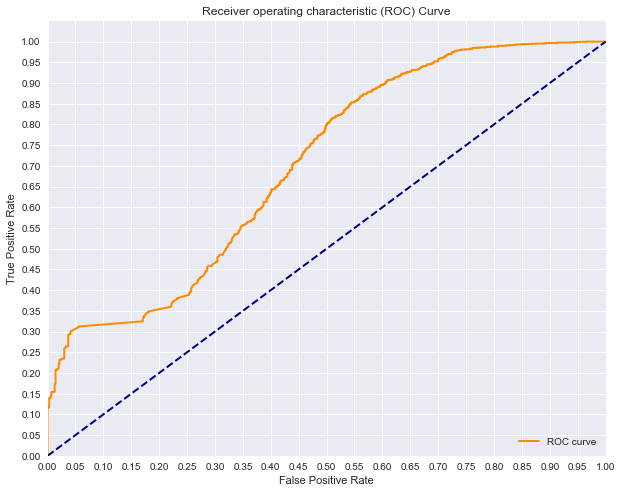

In [113]:
y_score = loreg.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Exporting model as pickle file to make predictions in flask app

In [ ]:
pickle.dump(loreg, open("pkl/model.pkl", "wb"))

In [ ]:
my_model = pickle.load(open("pkl/model.pkl", "rb"))

In [ ]:
my_model.predict(X_test)

In [ ]:
X_test.shape